## MiniLab SVM and Logistic Regression Modeling
### Data Mining 7331 Section 403
---
- Brian Coari
- Stephen Merritt
- Cory Thigpen
- Quentin Thomas

In this lab we will create a logistic regression model and a support vector machine model for podium finishes in the `Olympic` data set. We will assess how well each model performs and adjust model parameters to improve accuracy.

### Create Models

#### Data Augmentation and Preprocessing

To prepare the lab, we brought population data into the data set and changed all National Olympic Committee or `NOC` data points to match their corresponding `country`. For countries without entries in the worldbank URL we hard-coded the populations.

There were 106 observations in the data set not associated with a country, so we dropped them. These were `Refugee Athletes` and `Individual Olympic Athletes`.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#Combine existing data with population data from:
#https://data.world/worldbank/total-population-per-country/file/POP_TOTAL_DS2_en_v2.csv
df = pd.read_csv('~/olympics/data/athletes_cleaned_merged.csv')
df_pop = pd.read_csv('~/olympics/data/POP_TOTAL.csv', encoding = "ISO-8859-1")
df_pop = df_pop[['Country Code', '2015']]
#Change all Russia NOCs
df['NOC'] = np.where(df['NOC'] == 'EUN', 'RUS', df['NOC'])
df['NOC'] = np.where(df['NOC'] == 'URS', 'RUS', df['NOC'])
#Change all Australia NOCs
df['NOC'] = np.where(df['NOC'] == 'ANZ', 'AUS', df['NOC'])
#Change all German NOCs
df['NOC'] = np.where(df['NOC'] == 'FRG', 'GER', df['NOC'])
df['NOC'] = np.where(df['NOC'] == 'GDR', 'GER', df['NOC'])
df['NOC'] = np.where(df['NOC'] == 'SAA', 'GER', df['NOC'])
#Change all Congo NOCs
df['NOC'] = np.where(df['NOC'] == 'CGO', 'COD', df['NOC'])
#Change all Czech NOCs
df['NOC'] = np.where(df['NOC'] == 'BOH', 'CZE', df['NOC'])
df['NOC'] = np.where(df['NOC'] == 'TCH', 'CZE', df['NOC'])
#Change all Yemen NOCs
df['NOC'] = np.where(df['NOC'] == 'YAR', 'YEM', df['NOC'])
df['NOC'] = np.where(df['NOC'] == 'YMD', 'YEM', df['NOC'])
#Change all Greek NOCs
df['NOC'] = np.where(df['NOC'] == 'CRT', 'GRE', df['NOC'])
#Change all Zimbabwe NOCs
df['NOC'] = np.where(df['NOC'] == 'RHO', 'ZIM', df['NOC'])
#Change all Malaysia NOCs
df['NOC'] = np.where(df['NOC'] == 'MAL', 'MAS', df['NOC'])
df['NOC'] = np.where(df['NOC'] == 'NBO', 'MAS', df['NOC'])
#Change all Vietnam NOCs
df['NOC'] = np.where(df['NOC'] == 'VNM', 'VIE', df['NOC'])
#Change all Trinidad and Tobego NOCs
df['NOC'] = np.where(df['NOC'] == 'WIF', 'TTO', df['NOC'])
#Change all Trinidad and Tobego NOCs
df['NOC'] = np.where(df['NOC'] == 'UAR', 'SYR', df['NOC'])
#Change all Serbian NOCs
df['NOC'] = np.where(df['NOC'] == 'SCG', 'YUG', df['NOC'])
df['NOC'] = np.where(df['NOC'] == 'SRB', 'YUG', df['NOC'])
#Change all Canada NOCs
df['NOC'] = np.where(df['NOC'] == 'NFL', 'CAN', df['NOC'])
df_pop.rename(index = str, columns = {'Country Code' : 'NOC', '2015': '2015 Population'}, inplace = True)
df_pop_merge = pd.merge(left = df, right = df_pop, how = 'left', on=['NOC'], left_index=False)
df_pop_merge.loc[df_pop_merge['Country'] == 'Taiwan', '2015 Population'] =  23485755
df_pop_merge.loc[df_pop_merge['Country'] == 'Saint Vincent', '2015 Population'] =  109643
df_pop_merge.loc[df_pop_merge['Country'] == 'Palestine', '2015 Population'] =  4817000
df_pop_merge.loc[df_pop_merge['Country'] == 'Cook Islands', '2015 Population'] =  17459
df_pop_merge.loc[df_pop_merge['Country'] == 'Eritrea', '2015 Population'] =  4846976
df_pop_merge.loc[df_pop_merge['Country'] == 'Saint Kitts', '2015 Population'] =  54821
df_pop_mergena = df_pop_merge[df_pop_merge['2015 Population'].isnull()]
print(df_pop_mergena.groupby(['NOC', 'Country'])['NOC'].count())
#Drop the 106 observations not associated with a country 
df_pop_merge = df_pop_merge.dropna(how = 'any')

NOC  Country                    
IOA  Individual Olympic Athletes    94
ROT  Refugee Athlete                12
Name: NOC, dtype: int64


Calculate Ahtlete BMI, and add to the dataframe:

$$
BMI = \left(\frac{\omega}{\eta \eta}\right) C
$$

where $\omega$ represents our athletes weight in kilograms, and $\eta$ represents our athletes height in centimeters, and $C$ is our constant at `10,000`.

In [2]:
from pandas.plotting import scatter_matrix
def calculate_bmi(df):
    return (df[1]/(df[0] * df[0])) * 10000

df_pop_merge['BMI'] = df_pop_merge[['Height', 'Weight']].apply(calculate_bmi, axis=1)
df_pop = df_pop_merge.groupby(['Country'])['2015 Population'].mean().reset_index()
df_pop['Population_Prop'] = df_pop['2015 Population'].transform(lambda x: x / (x.sum()))
df_pop_merge = pd.merge(left = df_pop_merge, right = df_pop, how = 'left', on=['Country'], 
                        left_index=False)
df_pop_merge = df_pop_merge[['Country', 'Sex', 'Age', 'Height', 'Weight', 'Year', 'Season', 'Sport', 'Event', 'BMI', 
                             'Population_Prop', 'Medal']]
df_pop_merge.to_csv('~/olympics/data/pop_merge.csv')
df_pop_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266848 entries, 0 to 266847
Data columns (total 12 columns):
Country            266848 non-null object
Sex                266848 non-null object
Age                266848 non-null int64
Height             266848 non-null int64
Weight             266848 non-null int64
Year               266848 non-null int64
Season             266848 non-null object
Sport              266848 non-null object
Event              266848 non-null object
BMI                266848 non-null float64
Population_Prop    266848 non-null float64
Medal              266848 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 26.5+ MB


In [3]:
#Change Sex, Season, and Medal to numeric factors
df_pop_merge.loc[df_pop_merge['Medal'] == 'No Medal', 'Medal'] =  0
df_pop_merge.loc[df_pop_merge['Medal'] == 'Bronze', 'Medal'] =  1
df_pop_merge.loc[df_pop_merge['Medal'] == 'Silver', 'Medal'] =  1
df_pop_merge.loc[df_pop_merge['Medal'] == 'Gold', 'Medal'] =  1
df_pop_merge.loc[df_pop_merge['Season'] == 'Summer', 'Season'] =  1
df_pop_merge.loc[df_pop_merge['Season'] == 'Winter', 'Season'] =  0
df_pop_merge.loc[df_pop_merge['Sex'] == 'M', 'Sex'] =  1
df_pop_merge.loc[df_pop_merge['Sex'] == 'F', 'Sex'] =  0


y = df_pop_merge['Medal']
X = df_pop_merge.drop(['Medal'], axis = 1)

print(X.info())
print(y.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266848 entries, 0 to 266847
Data columns (total 11 columns):
Country            266848 non-null object
Sex                266848 non-null int64
Age                266848 non-null int64
Height             266848 non-null int64
Weight             266848 non-null int64
Year               266848 non-null int64
Season             266848 non-null int64
Sport              266848 non-null object
Event              266848 non-null object
BMI                266848 non-null float64
Population_Prop    266848 non-null float64
dtypes: float64(2), int64(6), object(3)
memory usage: 24.4+ MB
None
count    266848.000000
mean          0.147841
std           0.354943
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Medal, dtype: float64


Notice the `Id`, `NOC`, `Name`, `Team`, and `Games` variables were dropped due to lack of relevancy. Next we begin to change `Sex`, `Season`, and `Medal` to numeric factors with binary encoding.

**OneHot Encode object variables**



In [4]:
X = pd.get_dummies(X, columns = ['Country', 'Event', 'Sport'])
print(X.describe())

                 Sex            Age         Height         Weight  \
count  266848.000000  266848.000000  266848.000000  266848.000000   
mean        0.722786      25.330338     175.420948      71.017542   
std         0.447624       5.801661       9.869066      13.330644   
min         0.000000      10.000000     127.000000      25.000000   
25%         0.000000      21.000000     169.000000      62.000000   
50%         1.000000      24.000000     176.000000      71.000000   
75%         1.000000      28.000000     182.000000      78.000000   
max         1.000000      72.000000     226.000000     214.000000   

                Year         Season            BMI  Population_Prop  \
count  266848.000000  266848.000000  266848.000000    266848.000000   
mean     1979.016369       0.818185      22.904691         0.013419   
std        29.560519       0.385693       2.718862         0.028553   
min      1896.000000       0.000000       8.360954         0.000001   
25%      1960.000000   

`Country`, `Event`, and `Sport` have too many variables to perform this type of manipulation, so we move to one-hot encoding.  There are significant differences in the ranges of variables, which will necessitate standardization. `Height`, `Weight`, `BMI`, and `Age` continuous variables are on a different scale than the binary encoded variables, `Country`, `Sport`, `Event`, and `Medal`.  The `Population_Prop` variable is a percentage of the overall world population for a given country which also has a different scale. 

#### Logistic Regression Model Building

In [5]:
#Split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)
#Standardize the train and test set
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [6]:
#Run the Logistic Regression Model with 
lr = LogisticRegression(penalty = 'l2', C = 100.0, random_state = 1)

The `Medal` variable is heavily weighted for *Non-Podium Finishers*, or **0** class.  In the output from the *y.describe()* function from above, we note that the *mean* of *y* is 0.1478, meaning *Podium Finishers* account for roughly 15% of the data in the `Medal` class, with remaing 85% being *Non-Podium Finishers*.  To optimize this for future model training, we can look change the class_weight method in the logistic regression function.

In [7]:
#Fit the Logistic Regression Model
lr1_clf = lr.fit(X_train_std, y_train)

In [8]:
print(lr1_clf.score(X_train, y_train))
print(lr1_clf.predict_proba(X_test_std[:5, :]))

0.85215806781
[[ 0.91037915  0.08962085]
 [ 0.9249871   0.0750129 ]
 [ 0.81393278  0.18606722]
 [ 0.96445575  0.03554425]
 [ 0.81628006  0.18371994]]


Note that the accuracy of the model is roughly **85%** which is nearly identical to the amount of *Non-Podium Finishers* in the `Medal` class.  All the model is being asked to do is choose **0** for instance in the *y* vector to achieve a relatively high level of accuracy.  We will need to investigate dimensionality reduction techniques or look for better predictor variables.

In [9]:
print(lr1_clf.predict_proba(X_test_std[:5, :]).argmax(axis = 1))

[0 0 0 0 0]


In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
accuracies = cross_val_score(lr1_clf, X_train_std, y_train, cv=3) 
y_train_pred = cross_val_predict(lr1_clf, X_train_std, y_train, cv = 3)
lr1_clf_precision = precision_score(y_train, y_train_pred)
lr1_clf_recall = recall_score(y_train, y_train_pred)
print('Basic Logistic Regression Accuracies: ')
print(accuracies)
print('Model Precision: %0.3f' % (lr1_clf_precision))
print('Model Recall: %0.3f' % (lr1_clf_recall))
total = sum(accuracies)/len(accuracies)
print("Accuracy Accross 3 Folds: %0.3f" % (total))

Basic Logistic Regression Accuracies: 
[ 0.85713884  0.85716494  0.85640608]
Model Precision: 0.577
Model Recall: 0.120
Accuracy Accross 3 Folds: 0.857


Above we take the average of the 3 folds in order to determine the overall logistic regression accuracy. Our logistic regression accuracy using all  the scores into account comes out to **85.7%**.  The precision score of **57.7%** from above demonstrates that the model is currently struggling to predict *True Positive* results or actual *Podium Finishers* from `Medal`.  The **12%** recall demonstrates the model is producing a significant amount of *False Negatives*.

In [11]:
from sklearn import metrics as mt
y_hat = lr1_clf.predict(X_test_std) # get test set precitions

# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print("Test accuracy: %0.3f" % (acc))
print("confusion matrix\n", conf)

Test accuracy: 0.858
confusion matrix
 [[44818   662]
 [ 6904   986]]


The model performs roughly the same against the test dataset as it does against the training dataset, meaning there is no inherent bias in the model.  The model has only correctly identified 986 *Podium Finishers*, but incorrectly selected 6,904 *Podium Finishers* as *Non-Podium Finishers*.  Put more succinctly, there were 986 Ture Positives compared to 6,904 False Negatives, which led to a low recall score.  Next we'll examine some methods to negotiate the balancing act of improving recall, while not drastically degrading precision.

In [12]:
from sklearn.metrics import classification_report

y_true, y_pred = y_test, lr1_clf.predict(X_test_std)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.87      0.99      0.92     45480
          1       0.60      0.12      0.21      7890

avg / total       0.83      0.86      0.82     53370



#### Perform Model Hyperparameter Optimization via GridSearch

In [19]:
%%time

lr1 = LogisticRegression(random_state = 1)
from sklearn.model_selection import GridSearchCV
bal_dict = {0 : 0.15, 1 : 0.85}
parameters = {'penalty':('l1', 'l2'), 'C':[0.001, 0.01, 0.1, 1.0, 10.0], 
              'class_weight' : ('balanced', bal_dict)}
gs_clf = GridSearchCV(estimator = lr1, param_grid = parameters, cv = 3, n_jobs = -1, scoring = 'roc_auc')
gs_clf = gs_clf.fit(X_train_std, y_train)

CPU times: user 7min 13s, sys: 3min 45s, total: 10min 58s
Wall time: 17h 42min 37s


In [20]:
print(gs_clf.best_score_)
print(gs_clf.best_params_)

0.783145126286
{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1'}


The results of the GridSearch yielded a class_weight of *balanced*, which is significant due to the vast majority of the `Medal` variable belonging to Class 0.  GridSearch also selects the L1 regularization penalty:

$$
L1 = ||w||_{1} = \sum_{j=1}^{m} |w_{j}|
$$


This is a logical selection due to the high dimensionality and sparseness of the dataset following the OneHot Encoding procedure.  The selection of C as 0.01 is also logical as it is the inverse of the regularization strength, so a lower number will decrease any tendency to overfit.

In [21]:
clf = gs_clf.best_estimator_
clf.fit(X_train_std, y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [22]:
print(clf.score(X_train_std, y_train))
print(clf.predict_proba(X_test_std[:5, :]))

0.690769072223
[[ 0.63531496  0.36468504]
 [ 0.68906632  0.31093368]
 [ 0.43004939  0.56995061]
 [ 0.82007282  0.17992718]
 [ 0.47173807  0.52826193]]


In [23]:
print(clf.predict_proba(X_test_std[:5, :]).argmax(axis = 1))

[0 0 1 0 1]


In [24]:
accuracies = cross_val_score(clf, X_train_std, y=y_train, cv=3) # this also can help with parallelism
y_train_pred = cross_val_predict(clf, X_train_std, y_train, cv = 3)
clf_precision = precision_score(y_train, y_train_pred)
clf_recall = recall_score(y_train, y_train_pred)
print('Basic Logistic Regression Accuracies: ')
print(accuracies)
print('Model Precision: %0.3f' % (clf_precision))
print('Model Recall: %0.3f' % (clf_recall))

Basic Logistic Regression Accuracies: 
[ 0.68849073  0.69156396  0.68909063]
Model Precision: 0.288
Model Recall: 0.745


In [25]:
y_hat = clf.predict(X_test_std) # get test set precitions
clf_precision = precision_score(y_test, y_hat)
clf_recall = recall_score(y_test, y_hat)
print('Test Precision: %0.3f' % (clf_precision))
print('Test Recall: %0.3f' % (clf_recall))
# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print("accuracy", acc )
print("confusion matrix\n",conf)

Test Precision: 0.283
Test Recall: 0.738
accuracy 0.684897882706
confusion matrix
 [[30734 14746]
 [ 2071  5819]]


In [26]:
from sklearn.metrics import classification_report

y_true, y_pred = y_test, clf.predict(X_test_std)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.94      0.68      0.79     45480
          1       0.28      0.74      0.41      7890

avg / total       0.84      0.68      0.73     53370



Due to the large number of features associated with dataset following binary and OneHot Encoding of the categorical varibles, we will examine the weights of the coefficients only using the 30 most important features as determined by Recursive Feature Elimination function in sklearn. 

In [22]:
#The X_reduced dataframe is the result of running the Recursive Feature Elimination RFE funciton in sklearn 
#The code for this is below and typically takes 6-12 hours of run time depending on your machine.
X_reduced = X[['Country_USA', 'Country_Russia','Weight','Year','Sex','Country_Luxembourg','Country_Egypt',
               'Sport_Athletics','Season','Event_Ice  Ice Hockey','Event_ Individual All-Around',
               'Event_ Road Race, Individual','Event_ Rugby','Event_ Floor Exercise','Event_ Horse Vault',
               'Sport_Alpine Skiing','Event_ Team All-Around, Swedish System','Event_ Horizontal Bar',
               'Country_Mexico', 'Event_ Uneven Bars','Event_ Pommelled Horse','Country_Senegal',
               'Event_ Parallel Bars','Event_ Rings','Country_Ireland','Country_Venezuela',
               'Event_ Balance Beam', 'Country_Israel','Event_Sailing Mixed 12 metres','Event_ Lacrosse']]

In [ ]:
%%time

from sklearn.feature_selection import RFE
#Use parameters from GridSearch Results
lr_rfe =  LogisticRegression(penalty = 'l1', C = 0.01, random_state = 1, 
                                           class_weight = 'balanced')
#Use Recursive Feature elimination to determine feature importance
#THIS WILL TAKE APPROXIMATELY 6 HOURS TO FIT THE RFE model (790 Features x 266848 Obs)
rfe = RFE(lr_rfe, n_features_to_select = 1, verbose = True)
rfe_clf = rfe.fit(X_train_std, y_train)

In [ ]:
print("Features sorted by their rank:")
names = X.columns
sorted(zip(map(lambda x: round(x, 4), rfe_clf.ranking_), names))

In [ ]:
best_features = []
[best_features.append(t[1]) for t in ranks]
X_reduced = X[best_features]

#### SGD Classifier Linear Model

Next we examine the same dataset on a different model to determine the accuracy we can acheive. 

Here we are interested in determining whether or not the `RBF` or the `Linear` approach works best for this dataset. We look to try a range of `C` values as well as $\gamma$ values on the model in order to get a good idea of how good our model can be.

In [47]:
%%time
from sklearn.linear_model import SGDClassifier


sgd_classifier = SGDClassifier(max_iter=1000, n_jobs=-1, random_state=12, penalty='l2')
sgd_classifier.fit(X_train_std, y_train)

y_true, y_pred = y_test, sgd_classifier.predict(X_test_std)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.86      1.00      0.92     45480
          1       0.70      0.04      0.07      7890

avg / total       0.83      0.86      0.80     53370

CPU times: user 5min 14s, sys: 1.21 s, total: 5min 15s
Wall time: 5min 16s


With an $\alpha$ of `0.0001` and an $\epsilon$ of `0.1` we were able to achieve an average accruacy of 83%. For regularization we used the `l2` penalty in order to reach our most optimal classification.

### Model Advantages
---

#### Logistic Regression Results

First we tried the Logistic regression model on the entire dataset. We used a 3 fold cross validation in order to determine our final accuracy. The following Logistic Regression model used the following parameters...

|Param      | value|
|:---------:|:------:|
| Penalty    | L2    |
| C         |  100.0  |
| cv        |   3    |
| Dataset   | Full   |


The model above produced an accuracy of 83% during testing. In order to score the model we had to use precision and recall as a scoring metric as we are dealing with a binary classification method. The results are listed below...


|Class  | Precision  | Recall  |f1-score |  Support    |
|:-----:|:---------:|:-------:|:--------:|:------------:|
| 0 No Medal | 0.87 |  0.99   |  0.92    | 45480|
| 1 Medal    | 0.60 |   0.12  |  0.21    |  7890|
| avg / total | 0.83 |  0.86  |   0.82   | 53370 |

`LR Runtime 2min 56sec`

We then ran a GridSearch with 3-Fold Cross-Validation to optimize the Hyperparameters of the Logistic regression Model. GridSearch selected the following hyperparamters:

|Param      | value|
|:---------:|:------:|
| Penalty    | L1    |
| C         |  0.01  |
| cv        |   3    |
| class_weight   |  Balanced   |


The results are listed below...


|Class  | Precision  | Recall  |f1-score |  Support    |
|:-----:|:---------:|:-------:|:--------:|:------------:|
| 0 No Medal | 0.94 |   0.68  |   0.79   | 45480 |
| 1 Medal    | 0.28 |   0.74  |   0.41   | 7890  |
| avg / total | 0.84 |  0.68  |  0.73  |  53370  |

`GS Runtime 17hr 42min 37sec`

We can see above that the GridSearch model performs slightlty better than the non-optimized Model with an 84% accuracy.  The largest performance increase was in the Recall of the **1** class of `Medal`, increasing from 0.12 to 0.74.  The optimized model via GridSearch selected nearly 5,000 more *True Positive* Medal winners than non-optimized Model.  It is still easier for the model to tackle the **No medal** class because of the simple fact that 85% of all the athletes fall into this category.  Performing a GridSearch on the full dataset took a significant amount time to run, but it did produce a signficant increase in correctly identifying `Medal` *True Positives*.


#### SGD Linear Classifier Results

The next model was the Linear `SGD` model. This model used the following parameters...

|Param      | value|
|:---------:|:--------:|
| Penalty    | L2     |
| $\alpha$  |  0.0001|
| $\epsilon$ |   0.1  |
| Dataset   | Full   |


`SGD Runtime 3min 26sec`


This model held a 83% accuracy during testing on the dataset. The model trained much slower than n the `LRM` so if we wanted to sacrifice precision and recall for the sake of the speed of training time the logistic regression model would be the best choice.

Logistic Regression across 3 folds showed that it can receive an accuracy of 84% on our specific dataset. The good thing with this model is that it is so much easier to interpret the parameters and the probability in relation to our classification problem. The training time for this particular model was much faster than the SGD Classifier by a few minutes. This model also took into consideration that the no medal and medal classes were unevenly weighted, so 92% is much closer to a true accuracy.



The results are listed below...


|Class  | Precision  | Recall  |f1-score |  Support    |
|:-----:|:---------:|:-------:|:--------:|:------------:|
| 0 No Medal | 0.86 | 1.00 | 0.92 | 45480 |
| 1 Medal    | 0.70 |  0.04 | 0.07 | 7890|
| avg / total | 0.83 | 0.86 | 0.80 | 53370 |
|

We can see above that it was much easier for the model to tackle the No medal class because of the simple fact 85% of all the athletes falls into this category. It makes sense that it would be able to learn to classifier this category pretty quickly as our dataset is not exactly representative when it comes to medal winners.


#### SVC Classifier

Finally we located a reduced dataset using the RFE feature selection technique. This reduction in the dimensionality of data allowed us to take a SVM based approach to the data. Without reducing the dataset down it took an extra long time for our dataset to converge. The paramters we used to train this dataset are listed below...

|Param      | value|
|:---------:|:--------:|
| Kernel    | rbf      |
| C         |  1000     |
| $\gamma$ |   0.001    |
| Dataset   | Reduced   |




|Class | Precision | Recall | f1-score | Support |
|:-----:|:---------:|:--------:|:-------:|:--------:|
| 0 No Medal | 0.85 | 1.00 | 0.92 | 45480|
| 1 Medal    | 0.87 | 0.02 | 0.04 | 7890 |
| avg / total | 0.86 | 0.86 | 0.79 | 53370 |


`SVC Runtime 51min 31sec`

SVC using the `rbf` kernel produces a better accuracy, but where we gain in accuracy we lose in performance. It took almost an hour for the model to converge! This is something that we would need to think long and hard about if we decided to model this dataset with this particular model.

Logistic Regression across 3 folds showed that it can receive an accuracy of 84% on our specific dataset. The good thing with this model is that it is so much easier to interpret the paramters and the probability in relation to our classification problem. The training time for this particular model was much faster than the SGD Classifier by a few minutes. This model also took into consideration that the no medal and medal classes were unevenly weighted, so 92% is much closer to a true accuracy.


### Interpret Feature Importance
---
We will use the weights from logistic regression to interpret the importance of different features for `medal` winners. To do this we will split the data into train and test once again then run the model through a standard scaler operation. Lastly, we will run the logistic regression again on the reduced model to get a feel for how the logistic regressor interprets the coefficients.

In [17]:
#Split the data set into train and test
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_reduced, y, test_size = 0.2, random_state = 1, stratify = y)
#Standardize the train and test set
sc = StandardScaler()
sc.fit(X_train1)
X_train_std1 = sc.transform(X_train1)
X_test_std1 = sc.transform(X_test1)

#Run the Logistic Regression Model with 
lr_reduced = LogisticRegression(penalty = 'l1', C = 0.01, class_weight = {0: 0.15, 1: 0.85}, random_state = 1)
lr2_clf = lr_reduced.fit(X_train_std1, y_train1)

In [18]:
# iterate over the coefficients
weights_lr2 = lr2_clf.coef_.T
 # take transpose to make a column vector
variable_names_clf = X_reduced.columns
for coef, name in zip(weights_lr2,variable_names_clf):
    print(name, 'has weight of', coef[0])

Country_USA has weight of 0.257670577598
Country_Russia has weight of 0.25950733741
Weight has weight of 0.208645198335
Year has weight of -0.196516886445
Sex has weight of -0.201311922995
Country_Luxembourg has weight of -0.117382429775
Country_Egypt has weight of -0.152154300542
Sport_Athletics has weight of -0.257736306154
Season has weight of 0.208403958027
Event_Ice  Ice Hockey has weight of 0.125903560183
Event_ Individual All-Around has weight of -0.191738219999
Event_ Road Race, Individual has weight of -0.183318923483
Event_ Rugby has weight of 0.0782097371819
Event_ Floor Exercise has weight of -0.183017644565
Event_ Horse Vault has weight of -0.155086360898
Sport_Alpine Skiing has weight of -0.142871543001
Event_ Team All-Around, Swedish System has weight of 0.0817928006575
Event_ Horizontal Bar has weight of -0.122001499019
Country_Mexico has weight of -0.127976828369
Event_ Uneven Bars has weight of -0.112212281214
Event_ Pommelled Horse has weight of -0.120428734254
Count

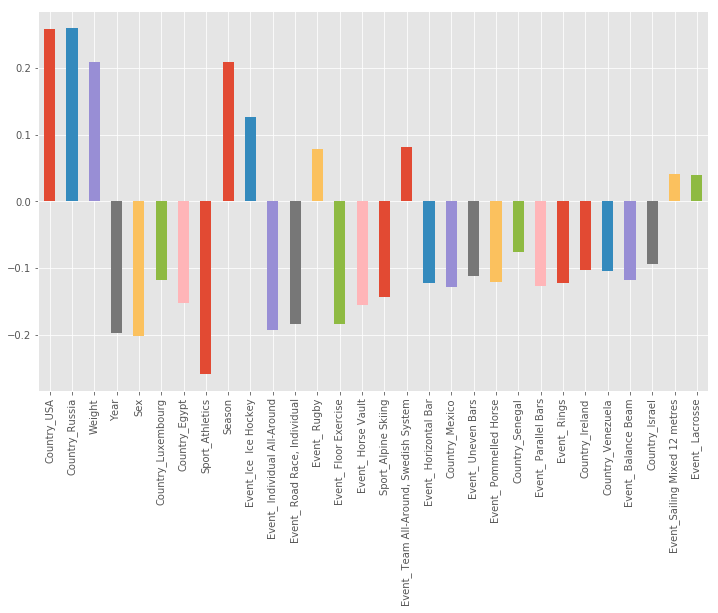

In [20]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(lr2_clf.coef_[0],index=X_reduced.columns)
weights.plot(kind='bar', figsize = (12, 7))
plt.show()

The 30 most important features in the model, as determined by RFE, can be found in the bar chart above.  `Country_USA`, `Country_Russia`, `Weight`, and `Season` are found to be the most important features when determining an athlete's probability to win a medal, or `Medal` class **1**.  `Sports_Athletics` is the most important feature when determining the probability of an athlete not winning a medal, or `Medal` class **0**.  This is logical because the largest number of overall athletes to compete in the Olympics typically compete in *Athletics*, or Track and Field events.  Meaning, they are less likely to win a Medal just based on the sheer number of participants.  Other items to note in the top-30 are countries which have historically not produced many `Medal` winners. 

#### Dimensionality reduction via PCA 

In [37]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(PCA(),
                        LogisticRegression(penalty = 'l1', C = 0.01, random_state = 1, 
                                           class_weight = 'balanced'))
pca = PCA()

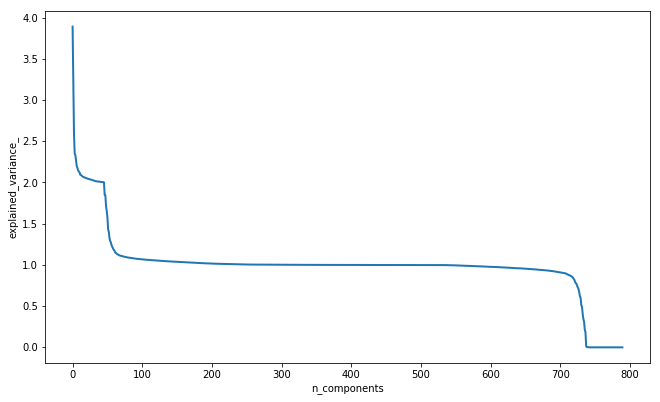

In [38]:
pca.fit(X_train_std)

plt.figure(1, figsize=(12, 7))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()

Utilizing a standard PCA model, there are distinct steps where variance decreases.  This provides the opportunity to minimize the curse of dimensionality and use GridSearch once again to attempt to optimize hyperparameters by choosing from a range of n_components utilizing PCA.

In [39]:
%%time

#Perform GridSearch with varying number of number of PCA components
param_grid = [{'pca__n_components': [20, 50, 100]}]

gs_clf = GridSearchCV(estimator = pipe_lr, param_grid = param_grid, cv = 5, n_jobs = -1, 
                      scoring = 'roc_auc', verbose = True)
gs_clf = gs_clf.fit(X_train_std, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 11.2min finished


CPU times: user 1min 27s, sys: 35.2 s, total: 2min 2s
Wall time: 11min 35s


In [42]:
print(gs_clf.best_score_)
print(gs_clf.best_params_)

0.699638990662
{'pca__n_components': 100}


In [43]:
clf = gs_clf.best_estimator_
clf.fit(X_train_std, y_train)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logisticregression', LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [44]:
print(clf.score(X_train_std, y_train))
print(clf.predict_proba(X_test_std[:5, :]))

0.658770458783
[[ 0.69396868  0.30603132]
 [ 0.51488703  0.48511297]
 [ 0.3756538   0.6243462 ]
 [ 0.59627138  0.40372862]
 [ 0.29959071  0.70040929]]


In [45]:
accuracies = cross_val_score(clf, X_train_std, y=y_train, cv=3) # this also can help with parallelism
y_train_pred = cross_val_predict(clf, X_train_std, y_train, cv = 3)
clf_precision = precision_score(y_train, y_train_pred)
clf_recall = recall_score(y_train, y_train_pred)
print('Basic Logistic Regression Accuracies: ')
print(accuracies)
print('Model Precision: %0.3f' % (clf_precision))
print('Model Recall: %0.3f' % (clf_recall))

Basic Logistic Regression Accuracies: 
[ 0.65743395  0.66075971  0.65512444]
Model Precision: 0.245
Model Recall: 0.624


In [46]:
y_hat = clf.predict(X_test_std) # get test set precitions
clf_precision = precision_score(y_test, y_hat)
clf_recall = recall_score(y_test, y_hat)
print('Test Precision: %0.3f' % (clf_precision))
print('Test Recall: %0.3f' % (clf_recall))
# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print("accuracy", acc )
print("confusion matrix\n",conf)

Test Precision: 0.244
Test Recall: 0.629
accuracy 0.656717256886
confusion matrix
 [[30083 15397]
 [ 2924  4966]]


You can see from above that even with 100 Principal components in the model, we are still unable to improve precision above our Optimized model from before.  Recall also decreased from 0.74 to 0.63.

In [48]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=clf, X=X_train_std, y=y_train, cv=10, scoring='roc_auc')
print("Logistic Regression ROC AUC: %0.2f, (+/- %0.2f)" % (scores.mean(), scores.std()))

Logistic Regression ROC AUC: 0.70, (+/- 0.00)


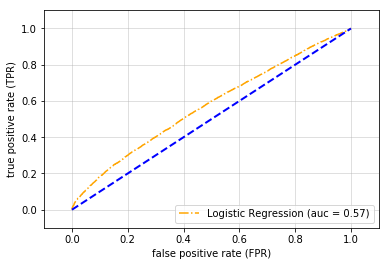

In [49]:
from sklearn.metrics import roc_curve, auc
y_pred = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred)
roc_auc = auc(x = fpr, y = tpr)
plt.plot(fpr, tpr, color = 'orange', linestyle = '-.', label = 'Logistic Regression (auc = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'blue', linewidth = 2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha = 0.5)
plt.xlabel('false positive rate (FPR)')
plt.ylabel('true positive rate (TPR)')
plt.legend(loc = 'lower right')
plt.show()

The ROC curve above provides a visual represetation of our True Positive Rate vs. False Positive Rate for the 
PCA-adjusted Logisitic Regression model.  The AUC of 0.57 is only slightly better than a best-guess estimate, so we will need to investigate stronger predictor variables for future classification attempts.

### Interpret Support Vectors
---

In [23]:
%%time
from sklearn.svm import SVC

#Avoids Running RFE Model a second time
svc = SVC(C=1000, gamma=0.001, kernel='rbf', random_state=12)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_reduced, y,
                                                        random_state = 1, stratify=y,
                                                       test_size=0.2)


sc.fit(X_train2)
X_train2_std = sc.transform(X_train2)
X_test2_std = sc.transform(X_test2)



svc.fit(X_train2_std, y_train2)

y_true, y_pred = y_test2, svc.predict(X_test2_std)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.85      1.00      0.92     45480
          1       0.87      0.02      0.04      7890

avg / total       0.86      0.86      0.79     53370

CPU times: user 1h 3min 22s, sys: 37.8 s, total: 1h 4min
Wall time: 1h 4min 30s


In [24]:
sum(svc.n_support_)

62596

Above we can see that there are a total of 62,596 support vectors when we look at our reduced dataset. We went from 709 features down to top 30 RFE features. These support vectors are broken by class by:

In [25]:
print("No Medal Class Number of Support Vectors :", svc.n_support_[0])
print("Medal Class Number of support Vectors : ", svc.n_support_[1])

No Medal Class Number of Support Vectors : 31473
Medal Class Number of support Vectors :  31123


This makes sense that the `no medal` class has a larger number of support vectors as there are more possibilities of not winning a medal in our dataset than there is of someone actually winning a medal.

In [26]:
svc.support_

array([    36,     54,     62, ..., 213470, 213471, 213476], dtype=int32)

In [27]:
X_reduced.iloc[10, :]

Country_USA                                  0
Country_Russia                               0
Weight                                      73
Year                                      1948
Sex                                          1
Country_Luxembourg                           0
Country_Egypt                                0
Sport_Athletics                              0
Season                                       1
Event_Ice  Ice Hockey                        0
Event_ Individual All-Around                 0
Event_ Road Race, Individual                 0
Event_ Rugby                                 0
Event_ Floor Exercise                        0
Event_ Horse Vault                           0
Sport_Alpine Skiing                          0
Event_ Team All-Around, Swedish System       0
Event_ Horizontal Bar                        0
Country_Mexico                               0
Event_ Uneven Bars                           0
Event_ Pommelled Horse                       0
Country_Seneg

If we examine our support vectors found by the SVC model, we can see that `Russia` and the `United States` are huge factors in determining whether or not an athelete medals. This finding corresponds to the fact that those two countries had the most medal winners in the dataset. Not being from those countries is more likely to result in an athlete not having a podium finish. `Sex` seems to determine whether an athlete will win a gold medal. This might have something to do with the fact that men had more data available for their Olympic finishes than women did. 1948 seemed to be a significant year that the Support Vector found. This corresponds to the uptick in gold medal wins that our gold medals over time graph showed in our EDA section. Finally, we notice that a `weight` of 73 Kilograms seems to be significant. The reason for this is unknown at the time, but could have something to do with lighter athletes being more likely to engage in events where there were a greater number of podium finishes. It's also expected to see the `Sport_Athletics` show up as a Support Vector because some sports are more likely to produce a high number of podium finishes than others. Our Support Vectors found by the SVC model do seem to be linked with some of the initial findings we highlighted during EDA.

In [29]:
X_reduced.to_csv('~/olympics/data/reduced_olympic_data.csv', header=True, index=False)